In [1]:
import pandas as pd
import numpy as np

import dask.dataframe as dd
import dask.array as da
import dask.bag as db
import dask
#dask.config.set({"optimization.fuse.active": True})

from custom_loader import Loader
from tqdm import tqdm


import re

#import bamboolib
import plotly.express as px

In [2]:
with open('cassandra-credentials.txt','r') as f:
    user = f.readline().strip()
    pw = f.readline().strip()

In [ ]:
dask_cassandra_loader = Loader()
keyspace = 'mav'
cluster = ['vm.niif.cloud.bme.hu']

dask_cassandra_loader.connect_to_cassandra(cluster,
                                           keyspace,
                                           username=user,
                                           password=pw, port=11352)
dask_cassandra_loader.connect_to_local_dask()

In [ ]:
#table = dask_cassandra_loader.load_cassandra_table('train_data',
#                                         ['epoch', 'relation', 'trainnumber', 'created', 'delay', 'elviraid', 'lat', 'line', 'lon', 'servicename'],
#                                                   [],
#                                         [('epoch', 'equal', [19221])],
#                                         [('epoch', [19221,19222])],
#                                         force=False)

In [ ]:
table = dask_cassandra_loader.load_cassandra_table('train_data',
                                         ['epoch', 'relation', 'trainnumber', 'created', 'delay', 'elviraid', 'lat', 'line', 'lon', 'servicename'],
                                                   [],
                                         #[('epoch', 'equal', [19221])],
                                         [('epoch', [0])],
                                         force=False)
table.data.compute()

In [49]:
bins = list(range(0,1000,5))
delays_binned = None
skipped = 0
zero = 0
#epoch range: 18628-19296 
for i in tqdm(range(18628,19296,5)):
    table = dask_cassandra_loader.load_cassandra_table('train_data',
                                             ['epoch', 'delay',],
                                                       [],
                                             #[('epoch', 'equal', [19221])],
                                             [('epoch', [i,i+1,i+2,i+3,i+4])],
                                             force=False)
    if table.data is None:
        skipped += 1
        continue
    df = table.data['delay'].map_partitions(pd.cut, bins)
    if delays_binned is None:
        tmp = df.compute()
        zero += len(tmp.isna())
        tmp = tmp.groupby(tmp).size()
        delays_binned = tmp
    else:
        tmp = df.compute()
        zero += len(tmp.isna())
        tmp = tmp.groupby(tmp).size()
        delays_binned = delays_binned + tmp
print(f'skipped {skipped*3}, zero count: {zero}')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 212/212 [06:47<00:00,  1.92s/it]

skipped 558, zero count: 25410643


In [66]:
plot_df = pd.DataFrame({'x':delays_binned.index,'y':delays_binned})
plot_df['x'] = plot_df['x'].astype(str)
plot_df = plot_df.head(50)

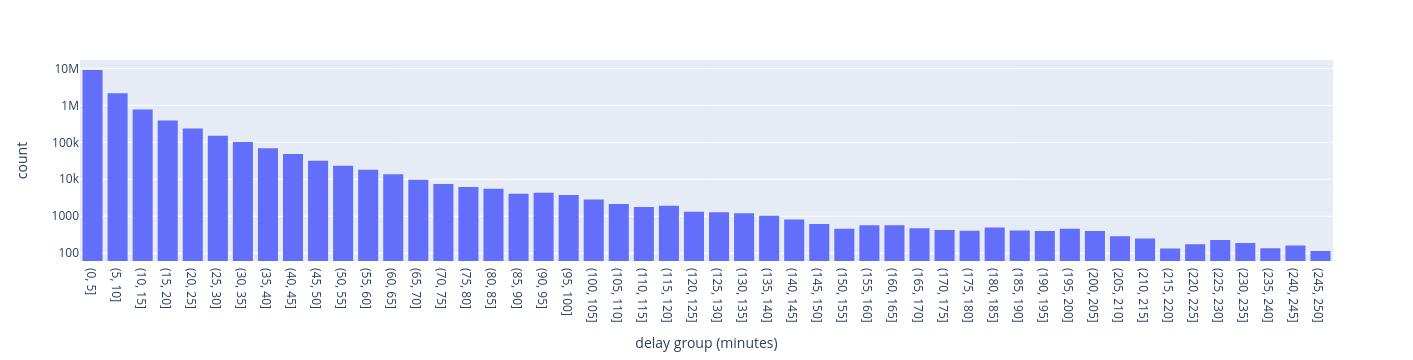

In [68]:
fig = px.histogram(plot_df,x='x', y='y')
fig.update_yaxes(type='log', title='count')
fig.update_xaxes(title='delay group (minutes)')
fig

In [63]:
cumul = None
for i in tqdm(range(18628,18675,5)):
    table = dask_cassandra_loader.load_cassandra_table('train_data',
                                             ['relation', 'delay',],
                                                       [],
                                             #[('epoch', 'equal', [19221])],
                                             [('epoch', [i,i+1,i+2,i+3,i+4])],
                                             force=False)
    if table.data is None:
        continue
    df = table.data.groupby('relation').agg({'delay':'mean'})
    if cumul is None:
        cumul = df.compute().reset_index()
        cumul['delay'] = np.where(cumul['delay'].isna(),0,cumul['delay'])
    else:
        tmp = df.compute().reset_index()
        tmp['delay'] = np.where(tmp['delay'].isna(),0,tmp['delay'])
        cumul = pd.concat([cumul, tmp]).groupby(by='relation').mean()

  0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?it/s]2022-12-11 01:31:57,203 - distributed.utils_perf - INFO - full garbage collection released 11.48 MiB from 906 reference cycles (threshold: 9.54 MiB)
2022-12-11 01:31:57,346 - distributed.utils_perf - INFO - full garbage collection released 9.68 MiB from 1360 reference cycles (threshold: 9.54 MiB)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:33<00:00, 15.34s/it]


In [66]:
def immutable_sort(list_to_sort:list) -> list:
    res = list_to_sort.copy()
    res.sort()
    return res

In [70]:
mean_delay_route = cumul.reset_index()
mean_delay_route['relation'] = mean_delay_route['relation'].apply(lambda x: x.split(' - '))
mean_delay_route['relation'] = mean_delay_route['relation'].apply(immutable_sort)
mean_delay_route['relation'] = mean_delay_route['relation'].astype(str)
mean_delay_route = mean_delay_route.groupby('relation').mean().reset_index()
mean_delay_route = mean_delay_route.sort_values(by=['delay'], ascending=[False])
mean_delay_route

,relation,delay
83,"['Budapest-Keleti', 'Pécel']",25.209302
73,"['Budapest-Keleti', 'Innsbruck Hbf.']",16.271654
161,"['Debrecen', 'Szerencs']",16.005155
40,"['Bucureşti Nord', 'Wien Hbf']",15.816797
106,"['Budapest-Nyugati', 'Praha hl. n.']",15.466003
...,...,...
233,"['Jászapáti', 'Újszász']",0.049808
187,"['Fehérgyarmat', 'Zajta']",0.047306
29,"['Battonya', 'Mezőhegyes']",0.031416
366,"['Vaja-Rohod', 'Vásárosnamény']",0.011236
